## Background

Managing missed patient appointments represent a challenge for those working in
health care systems.Non-attendance at appointments decreases healthcare revenue, causes suboptimal use of clinical and administrative staff, can impact wait times for patients, and negatively affects continuity of care.
The first step to solving the problem of missed appointments is identifying why a patient skips a scheduled visit in the first place. What trends are there among patients with higher absence rates? Are there demographic indicators or perhaps time-variant relationships hiding in the data? Ultimately, it was these questions that drove my exploratory data analysis. I was curious as to the reasons behind missed appointments, and wanted to examine the data to identify any trends present. I choose this problem because I believe it is an excellent example of how data science and analysis can reveal relationships which can be implemented in the real-world to the benefit of society.

## Introduction to Dataset

I wanted to choose a dataset that was both relatable and could be used to make 
smarter decisions. Therefore, I decided to work with medical appointment no shows 
data available on Kaggle.
There were a total of 14 variables I included from the original data. The variables and the description of the values are as follows:
1. PatientId: unique ID associated with a patient
2. AppointmentID: unique ID for each appointment.
3. Gender:  M or F
4. ScheduledDay :  date and time appointment was Scheduled.    
5. AppointmentDay : date of appointment without time.
6. Age : Integer age of patient.         
7. Neighbourhood :  Neighbourhood of the hospital.  
8. Scholarship : 0 or 1 indicating whether the family of the patient takes part in the Bolsa Familia Program     
9. HyperTension  :0 or 1 for condition
10. Diabetes  :  0 or 1 for condition (1 means patient was scheduled to treat condition)       
11. Alcoholism :  0 or 1 for condition    
12. HandiCap  : 0 or 1 for condition       
13. SMS_received  :  0 or 1 (1 for sending remainder)
14. No-show :  'Yes'/'No'


import necessary libraries

In [1]:
# make jupyter cells wider

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import datetime as datetime
from sklearn import preprocessing
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import chi2_contingency
from copy import deepcopy

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, roc_auc_score, classification_report, cohen_kappa_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV



import matplotlib
#matplotlib.style.use('ggplot')
sns.set(font_scale=1.5)

In [71]:
no_showup=pd.read_csv('C:/Users/Lenovo/Downloads/noshowappointments/KaggleV2-May-2016.csv')
no_showup.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## Data wrangling:

Let’s take a look at the structure of the dataframe to identify cleaning that may need to be performed. I am renaming few of the columns to appropriate names. data is already clean without any missing values.

In [72]:
no_showup.rename(columns = {'Hipertension':'HyperTension' , 'Handcap':'HandiCap','No-show':'no_show'},inplace=True)
no_showup.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'HyperTension',
       'Diabetes', 'Alcoholism', 'HandiCap', 'SMS_received', 'no_show'],
      dtype='object')

In [73]:
no_showup.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
HyperTension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
HandiCap          110527 non-null int64
SMS_received      110527 non-null int64
no_show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [74]:
#droping the column if all the values are null
no_show=no_showup.dropna(axis='columns',how='all')


In [75]:
no_show.describe()

,PatientId,AppointmentID,Age,Scholarship,HyperTension,Diabetes,Alcoholism,HandiCap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [76]:
#selecting the valid age
#no_show = no_show[(no_show.Age > 0) & (no_show.Age <= 100)]
no_show['no_show'] = no_show['no_show'].map({'No': 1, 'Yes': 0})

In [77]:

#get data and time from scheduled_day and appointment_day
no_show['ScheduledDay'] = pd.to_datetime(no_show['ScheduledDay'], infer_datetime_format=True)
no_show['AppointmentDay'] = pd.to_datetime(no_show['AppointmentDay'], infer_datetime_format=True)
 
no_show['WaitTime'] = list(map(lambda x: x.days+1 , no_show['AppointmentDay'] - no_show['ScheduledDay']))

#removing incorrect entries where appointment day was before the scheduled day which is not possible
no_show.drop(no_show[no_show['WaitTime'] <= -1].index, inplace=True)



In [78]:
# from waiting time created a column range according to the length of waiting time.(<1 month,>1 and <2 month...etc)
no_show['waiting_time_range'] = no_show['WaitTime'].apply(lambda x: 1 if x>=0 and x<=30 else 
                                                          2 if x>30 and x<=60 else 
                                                          3 if x>60 and x<=90 else 
                                                          4 if x>90 and x<=120 else 
                                                          5 if x>120 and x<=150 else
                                                          6 if x>150 and x<=180 else
                                                          7)

In [10]:
#created risk score column by calculating (no of appointments they didn't show up/ total appointment booked)
no_show['no_of_noshows'] = no_show.groupby('PatientId')[['no_show']].transform('sum')
no_show['total_appointment'] = no_show.groupby('PatientId')[['no_show']].transform('count')

no_show['risk_score'] = no_show.no_of_noshows / no_show.total_appointment

In [79]:
# checking if there are any missing values

no_show.fillna('')
no_show.isnull().values.any()


False

In [80]:
for i in no_show.columns:
    unique_count=no_show[i].nunique()
    if unique_count < 20:
       print(no_show[i].value_counts())
       print('---------')
       print('\n')

F    71837
M    38685
Name: Gender, dtype: int64
---------


0    99661
1    10861
Name: Scholarship, dtype: int64
---------


0    88721
1    21801
Name: HyperTension, dtype: int64
---------


0    102579
1      7943
Name: Diabetes, dtype: int64
---------


0    107162
1      3360
Name: Alcoholism, dtype: int64
---------


0    108283
1      2040
2       183
3        13
4         3
Name: HandiCap, dtype: int64
---------


0    75040
1    35482
Name: SMS_received, dtype: int64
---------


1    88208
0    22314
Name: no_show, dtype: int64
---------


1    100144
2      8283
3      1878
4       132
6        56
5        29
Name: waiting_time_range, dtype: int64
---------




In [81]:
#converting gender and no-show columns to numeric values
le = preprocessing.LabelEncoder()
le.fit(['F', 'M'])
no_show['num_gender']=le.transform(no_show['Gender'])


In [82]:
# there is 1 invalid record which is negative. I am selecting only the valid age.
no_show=no_show[no_show.Age>=0]

The summary of the no_show dataframe gives lot of details. Minimum age is 0 and maximum age is 115. Since there are only 4 patients with age greater then 100. I am considering it as valid.
This data summary shows that 20% of appointments are missed based on the mean for the numNoshow field. The rates for the various patient conditions can also be seen, and the most commonly coded reason for an appointment is hypertension at nearly 19.7% of visits.

In [83]:
def get_age_bucket(age):
    if age <= 18:
        return '0-18'
    elif 18 < age <= 24:
        return '18-24'
    elif 25 <= age <=34:
        return '25-34'
    elif 35 <= age <= 44:
        return '35-44'
    elif 45 <= age <= 54:
        return '45-54'
    elif 55 <= age <= 64:
        return '55-64'
    elif 65 <= age:
        return '65+'
    else:
        return '100+'
    
no_show['age_bucket'] = no_show['Age'].apply(lambda x: get_age_bucket(x))

In [84]:
# single function to visualize feature counts and relationship with no show

def visualize_feature(df, feature):
    if no_show[feature].nunique()> 4:
        figsize = (18, 8)
    else:
        figsize = (8, 3)
        
    if feature in ['age_bucket','Neighbourhood','WaitTime','day','month']:
        kind = 'bar'
    else:
        kind = 'barh'
        
    sort_column = feature    
    p = no_show.pivot_table(index=feature, values='no_show', aggfunc={'no_show': ['count', 'mean']}).reset_index()
    p['count%'] = p['count'] / p['count'].sum()
   # p['mean']=1-p['mean']
    p = p[[feature, 'count', 'count%', 'mean']]
    p.rename(index=str, columns={'mean': 'probability'}, inplace=True)
    display(p.round({'count%': 3, 'probability': 3}).sort_values(by='probability', ascending=False))
    pivot_mean = no_show.pivot_table(index=feature, values='no_show', aggfunc='mean').reset_index().sort_values(by=sort_column, ascending=True)
    pivot_mean['noshow'] = pivot_mean['no_show']   
    if feature=='day':
        dict_week = {'Monday': 1,'Tuesday': 2,'Wednesday': 3,'Thursday': 4,'Friday': 5,'Saturday': 6, 'Sunday': 0}
        pivot_mean[feature]=sorted(pivot_mean[feature], key=dict_week.__getitem__)
        ax = pivot_mean.plot(x=feature, y='noshow', kind=kind, figsize=figsize, colormap='Set2', title = 'No-show by %s' %feature, legend=False)
        ax.set_xlabel(feature)
        ax.set_ylabel('probability ')
    else:
        ax = pivot_mean.plot(x=feature, y='noshow', kind=kind, figsize=figsize, colormap='Set2', title = 'No-show by %s' %feature, legend=False)
        ax.set_xlabel(feature)
        ax.set_ylabel('probability ')
    if  kind == 'barh': 
        ax.set_xlabel('probability ')
        ax.set_ylabel(feature)
    plt.show()

,month,count,count%,probability
2,6,26450,0.239,0.815
0,4,3235,0.029,0.804
1,5,80836,0.731,0.792


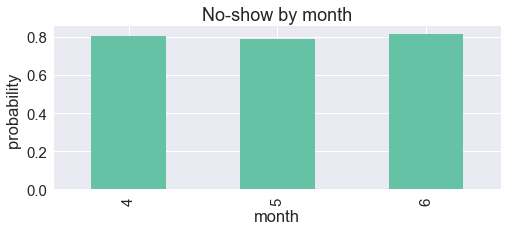

In [85]:
no_show['month'] = no_show['AppointmentDay'].dt.month
visualize_feature(no_show, 'month')

Month May has maximum no-shows.

,day,count,count%,probability
3,Thursday,17246,0.156,0.807
5,Wednesday,25866,0.234,0.803
4,Tuesday,25638,0.232,0.799
1,Monday,22713,0.206,0.794
0,Friday,19019,0.172,0.788
2,Saturday,39,0.000,0.769


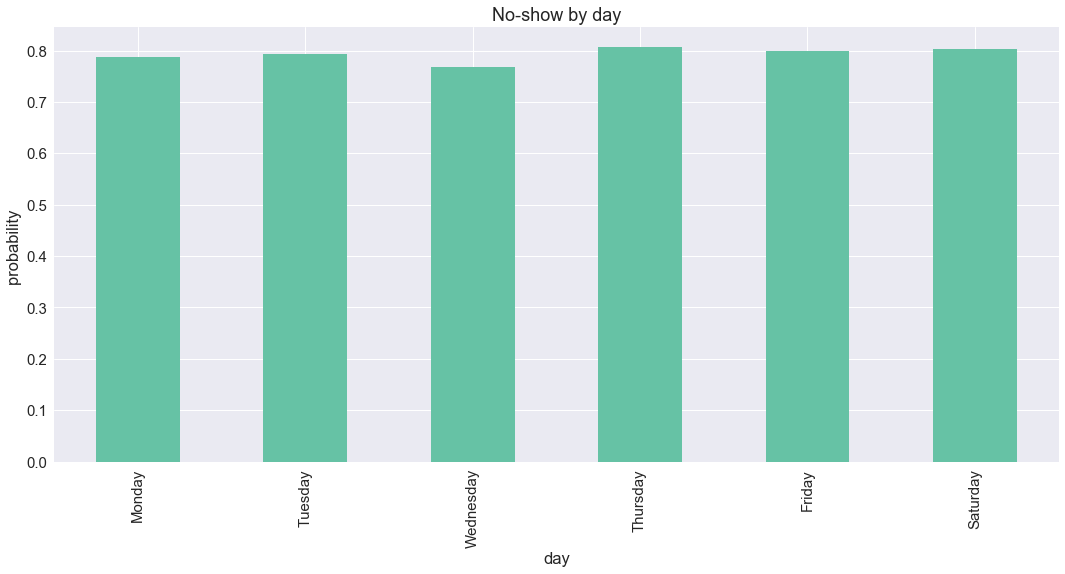

In [86]:
no_show['day']=no_show['AppointmentDay'].dt.weekday_name
visualize_feature(no_show, 'day')

Tuesday and Wednessday are busy days with more patient appointments.Saturday has least appointments probably because saturday is off.However there is no significant difference on no-show rate.

,waiting_time_range,count,count%,probability
0,1,100143,0.906,0.811
3,4,132,0.001,0.795
2,3,1878,0.017,0.712
5,6,56,0.001,0.679
1,2,8283,0.075,0.658
4,5,29,0.000,0.621


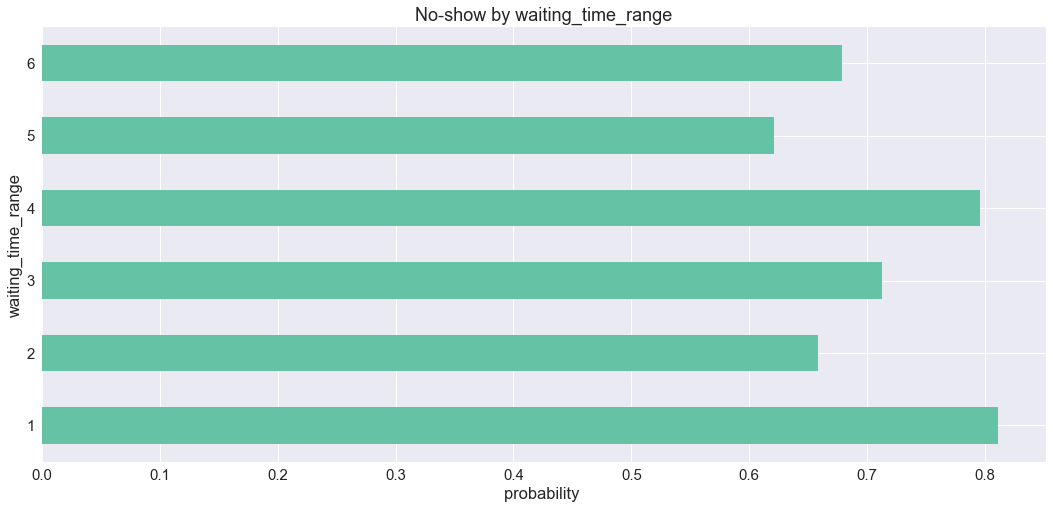

In [87]:

visualize_feature(no_show, 'waiting_time_range')

90% of patients wait less than a month.

,Gender,count,count%,probability
1,M,38685,0.35,0.800
0,F,71836,0.65,0.797


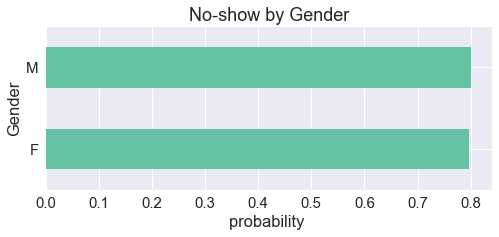

In [88]:
visualize_feature(no_show, 'Gender')

Females patients are 3.3 times more than male however there is no significant difference on no-show rate.

Percentage of no show up is more among female patients. There are much more women data than men data in the dataset.

,HandiCap,count,count%,probability
1,1,2040,0.018,0.822
0,0,108282,0.980,0.798
2,2,183,0.002,0.798
3,3,13,0.000,0.769
4,4,3,0.000,0.667


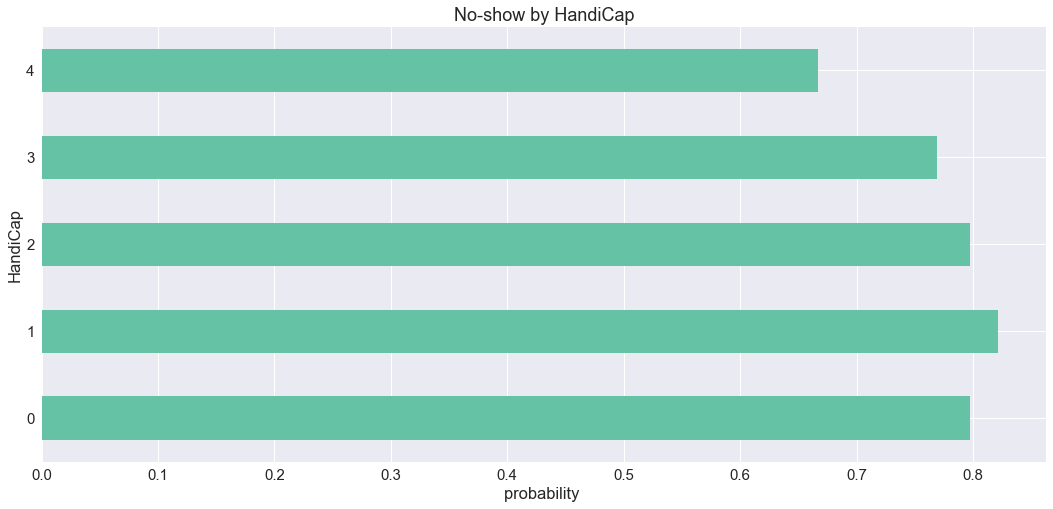

In [89]:
visualize_feature(no_show, 'HandiCap')

About 2% of the patients are handicap.

Patients with disability=4 tend to not miss the appointment much.

,Scholarship,count,count%,probability
0,0,99660,0.902,0.802
1,1,10861,0.098,0.763


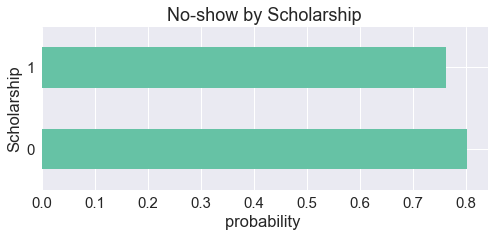

In [90]:
visualize_feature(no_show, 'Scholarship')

About 10% of the patients receive the scholarship and patients who don't receive the scholarship tend to miss the appointment more.

,Diabetes,count,count%,probability
1,1,7943,0.072,0.820
0,0,102578,0.928,0.796


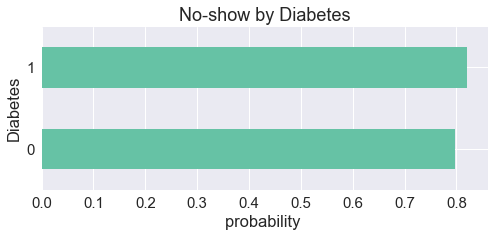

In [91]:
visualize_feature(no_show, 'Diabetes')

,Alcoholism,count,count%,probability
1,1,3360,0.03,0.799
0,0,107161,0.97,0.798


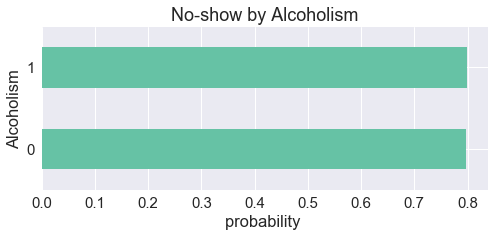

In [92]:
visualize_feature(no_show, 'Alcoholism')

Patients who are alcoholic show up more to thier appointment when compared to patients who are not alcoholic. but the difference is not significant.

,HyperTension,count,count%,probability
1,1,21801,0.197,0.827
0,0,88720,0.803,0.791


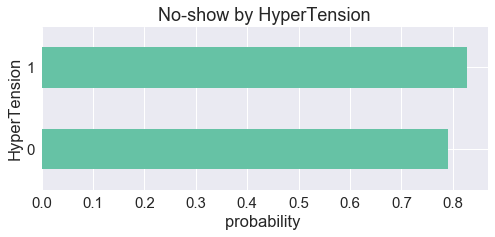

In [93]:
visualize_feature(no_show, 'HyperTension')

About 20% of the patients have hypertension. no-show is more for Patients with hypertension.

,SMS_received,count,count%,probability
0,0,75039,0.679,0.833
1,1,35482,0.321,0.724


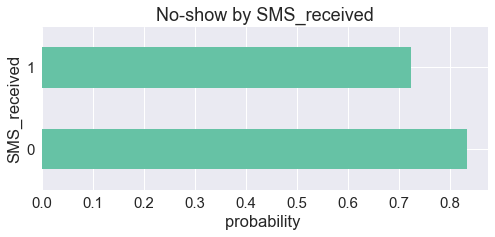

In [94]:
visualize_feature(no_show, 'SMS_received')

no show for patients who receivd email is slightly more. 

,age_bucket,count,count%,probability
6,65+,14401,0.130,0.845
5,55-64,14527,0.131,0.840
4,45-54,15465,0.140,0.817
3,35-44,14506,0.131,0.785
0,0-18,28865,0.261,0.780
2,25-34,14358,0.130,0.767
1,18-24,8399,0.076,0.748


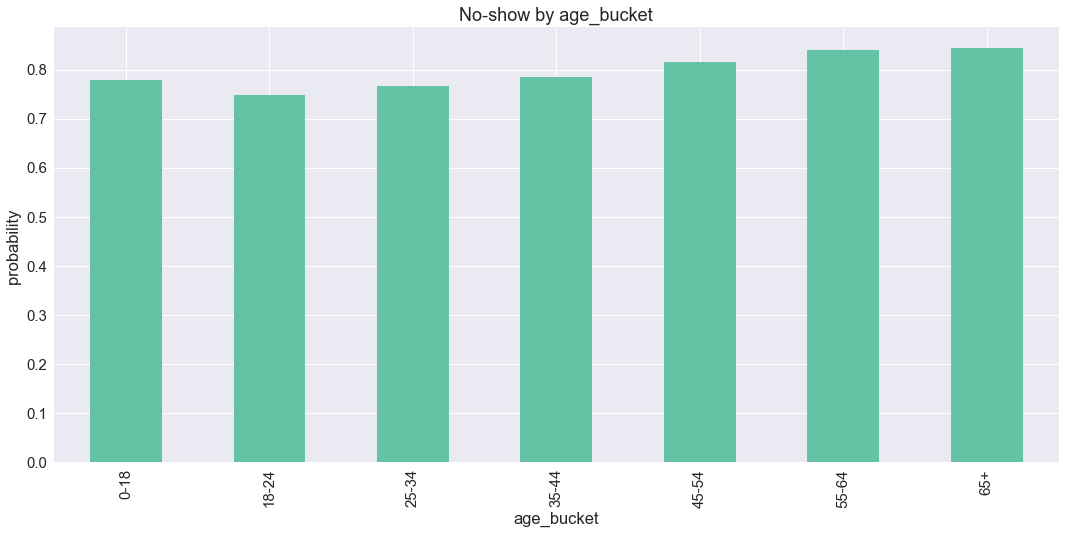

In [95]:
visualize_feature(no_show, 'age_bucket')

No show is decreasing  as the age is increasing

,Neighbourhood,count,count%,probability
51,PARQUE INDUSTRIAL,1,0.000,1.000
31,ILHA DO BOI,35,0.000,0.914
0,AEROPORTO,8,0.000,0.875
48,MÁRIO CYPRESTE,371,0.003,0.854
73,SOLON BORGES,469,0.004,0.853
16,DE LOURDES,305,0.003,0.846
17,DO CABRAL,560,0.005,0.843
66,SANTA MARTHA,3131,0.028,0.842
39,JARDIM DA PENHA,3877,0.035,0.837
19,DO QUADRO,849,0.008,0.835


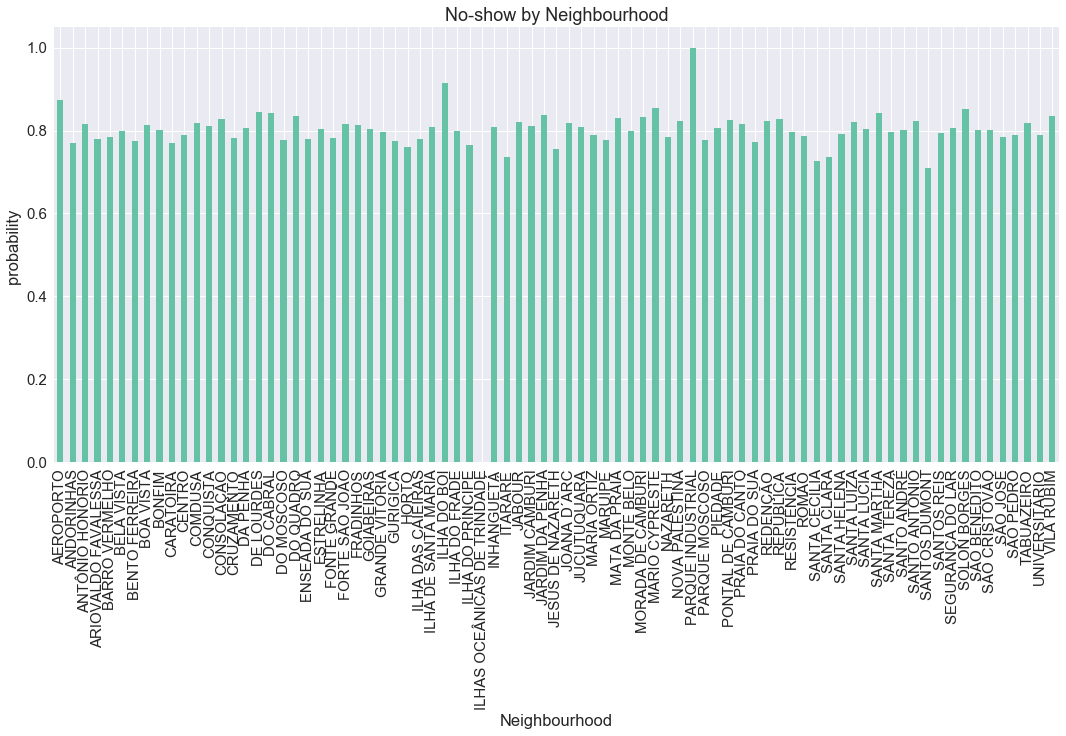

In [96]:
visualize_feature(no_show, 'Neighbourhood')

JARDIM CAMBURI Neighbourhood has more patients about 7% with 74% no show.

,Age,Neighbourhood,Scholarship,HyperTension,Diabetes,Alcoholism,HandiCap,SMS_received,no_show,WaitTime,num_gender,month,numday
Age,1.000000,-0.016349,-0.092469,0.504599,0.292398,0.095811,0.078101,0.012629,0.060320,0.034813,-0.106439,0.014569,0.003043
Neighbourhood,-0.016349,1.000000,0.006879,0.004343,0.011358,-0.000003,0.010888,0.018297,0.009023,-0.002025,-0.008075,0.002308,0.000564
Scholarship,-0.092469,0.006879,1.000000,-0.019738,-0.024899,0.035019,-0.008555,0.001182,-0.029166,-0.030435,-0.114297,-0.002589,-0.000682
HyperTension,0.504599,0.004343,-0.019738,1.000000,0.433082,0.087967,0.080162,-0.006285,0.035662,-0.017236,-0.055721,0.003776,0.003442
Diabetes,0.292398,0.011358,-0.024899,0.433082,1.000000,0.018471,0.057578,-0.014561,0.015158,-0.027200,-0.032555,0.003739,0.006607
Alcoholism,0.095811,-0.000003,0.035019,0.087967,0.018471,1.000000,0.004668,-0.026154,0.000181,-0.038527,0.106170,0.003919,0.002696
HandiCap,0.078101,0.010888,-0.008555,0.080162,0.057578,0.004668,1.000000,-0.024097,0.006290,-0.019774,0.022787,-0.001430,0.004461
SMS_received,0.012629,0.018297,0.001182,-0.006285,-0.014561,-0.026154,-0.024097,1.000000,-0.126502,0.398128,-0.046301,0.108070,-0.089880
no_show,0.060320,0.009023,-0.029166,0.035662,0.015158,0.000181,0.006290,-0.126502,1.000000,-0.186320,0.004132,0.020841,-0.001189
WaitTime,0.034813,-0.002025,-0.030435,-0.017236,-0.027200,-0.038527,-0.019774,0.398128,-0.186320,1.000000,-0.028411,0.003848,-0.011341


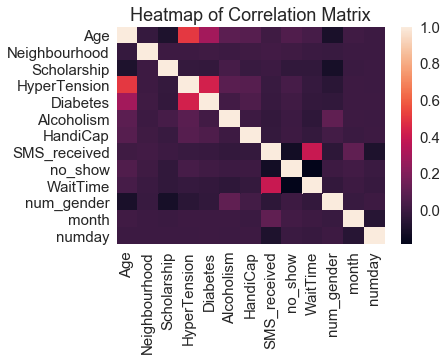

In [99]:
no_show['numday']=no_show['AppointmentDay'].dt.weekday
le = preprocessing.LabelEncoder()
no_show['Neighbourhood'] = le.fit_transform(no_show['Neighbourhood'])

no_show_corr=no_show.drop(['PatientId','AppointmentID','Gender','age_bucket','waiting_time_range'],axis=1)
corr=no_show_corr.corr()
corr = (corr)
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr


From the above correlation graph, there are no strong relationship to determine whether or not a patient will miss a visit (given by the numNoshows column). It appears that there are not even any strong relationships whatsoever though there is a moderate relationship between age and hypertension.

###  Inferential Statistics

### Analyzing relation between no-show and Gender

In [30]:
import scipy.stats as stats

noshow = np.array(no_show.Age[no_show.no_show == 0])
show = np.array(no_show.Age[no_show.no_show == 1])

stats.ttest_ind(noshow,show,equal_var=False,nan_policy='omit')


Ttest_indResult(statistic=-20.828722438301273, pvalue=8.703951340185734e-96)

NULL HYPOTHESIS: There is no Geneder effect regarding those who miss the appointmnet( Sample mean of male=sample mean of female)
ALTERNATE HYPOTHESIS:There is Geneder effect regarding those who miss the appointmnet( Sample mean of male != sample mean of female)

In [31]:
female = np.array(no_show.no_show[no_show.Gender == 'F'])
male = np.array(no_show.no_show[no_show.Gender == 'M'])

stats.ttest_ind(female,male,equal_var=False)

Ttest_indResult(statistic=-1.3762907786839724, pvalue=0.16873549634686227)

p-value=0.53 > 0.05 (significance level) so we can not reject the null hypothesis, which implies There is no Geneder effect on no-show.

### month analysis
NULL HYPOTHESIS: There is no month effect on no-shows ( sample means of all the months are same)
ALTERNATE HYPOTHESIS: There is effect of month on no-shows ( some of sample means of the months are not same)

In [32]:
import calendar    
monthName = no_show['month'].apply(lambda x: calendar.month_name[x])
monthName=monthName.unique()

In [33]:
anova_month = pd.DataFrame({"month":no_show['month'].apply(lambda x: calendar.month_name[x]),"noshow":no_show['no_show']})
groups = anova_month.groupby("month").groups

# Etract individual groups
April = no_show['no_show'][groups["April"]]
May = no_show['no_show'][groups["May"]]
June = no_show['no_show'][groups["June"]]

# Perform the ANOVA
stats.f_oneway(April,May,June)

F_onewayResult(statistic=33.823341256192954, pvalue=2.0663470501593316e-15)

Based on P-Value, which is less than significant value=0.05 we can reject the NULL hypothesis.so some of the sample means of the months is different.We can not determine for which month sample mean is different.

Post-hoc test is used to find for which month sample mean is different.

### post-hoc test is to perform a separate t-test for each pair of groups.

In [34]:
# Get all month pairs
month_pairs = []

for month1 in range(2):
    for month2  in range(month1+1,3):
        month_pairs.append((monthName[month1], monthName[month2]))

# Conduct t-test on each pair
for month1, month2 in month_pairs: 
    print(month1, month2)
    print(stats.ttest_ind(no_show['no_show'][groups[month1]], 
                          no_show['no_show'][groups[month2]]))

April May
Ttest_indResult(statistic=1.6705920208013705, pvalue=0.09480601201977179)
April June
Ttest_indResult(statistic=-1.5319393029446733, pvalue=0.12554807062954093)
May June
Ttest_indResult(statistic=-8.173091898390496, pvalue=3.0381923514162332e-16)


Based on P-value of month pairs, may,june pair has sample mean different.

### weekday analysis

NULL HYPOTHESIS: There is no weekday effect on no-shows ( sample means of all the weekdays are same)
ALTERNATE HYPOTHESIS: There is effect of weekday on no-shows ( some of sample means of the weekdays are not same)

In [35]:
weekday_df = pd.DataFrame({"day":no_show['day'],"noshow":no_show['no_show']})
groups = weekday_df.groupby("day").groups
weekday=no_show['day'].unique()
# Etract individual groups
Monday = no_show['no_show'][groups["Monday"]]
Tuesday = no_show['no_show'][groups["Tuesday"]]
Wednesday = no_show['no_show'][groups["Wednesday"]]
Thursday = no_show['no_show'][groups["Thursday"]]
Friday = no_show['no_show'][groups["Friday"]]
Saturday = no_show['no_show'][groups["Saturday"]]


# Perform the ANOVA
stats.f_oneway(Monday,Tuesday,Wednesday,Thursday,Friday,Saturday)

F_onewayResult(statistic=5.51955143477407, pvalue=4.367746993395855e-05)

In [36]:
# Get all weekday pairs
weekday_pairs = []

for wkday1 in range(5):
    for wkday2  in range(wkday1+1,6):
        weekday_pairs.append((weekday[wkday1], weekday[wkday2]))

# Conduct t-test on each pair
for wkday1,wkday2 in weekday_pairs: 
    print(wkday1,wkday2)
    print(stats.ttest_ind(no_show['no_show'][groups[wkday1]], 
                          no_show['no_show'][groups[wkday2]]))

Friday Tuesday
Ttest_indResult(statistic=-2.943963457071001, pvalue=0.003242050938267981)
Friday Monday
Ttest_indResult(statistic=-1.455022927075494, pvalue=0.14567043630924748)
Friday Wednesday
Ttest_indResult(statistic=-4.006183603971126, pvalue=6.180708841189068e-05)
Friday Thursday
Ttest_indResult(statistic=-4.435638459800174, pvalue=9.206954872788174e-06)
Friday Saturday
Ttest_indResult(statistic=0.28233563175591525, pvalue=0.7776892325195678)
Tuesday Monday
Ttest_indResult(statistic=1.518856405206274, pvalue=0.1288051830458258)
Tuesday Wednesday
Ttest_indResult(statistic=-1.1408314125933248, pvalue=0.2539453906263538)
Tuesday Thursday
Ttest_indResult(statistic=-1.8807659181988168, pvalue=0.06001053885243948)
Tuesday Saturday
Ttest_indResult(statistic=0.4655725656695368, pvalue=0.641525432989138)
Monday Wednesday
Ttest_indResult(statistic=-2.6286913079636673, pvalue=0.008574109983606235)
Monday Thursday
Ttest_indResult(statistic=-3.200990098535132, pvalue=0.0013706332039675878)
Mo

corrected significance level=0.05/15 is 0.003. 

### Analyzing between no-show ups and health condition

NULL HYPOTHESIS: There is no effect between health condition and no-shows ( sample means of all the health conditions is same)
ALTERNATE HYPOTHESIS: There is some effect between health condition and no-shows ( some of sample means of the weekdays are not same)

In [37]:
stats.f_oneway(no_show['HyperTension'],no_show['Diabetes'],no_show['Alcoholism'],no_show['HandiCap'])
 

F_onewayResult(statistic=10299.038933074067, pvalue=0.0)

Based on the P-value, we can not reject the NULL hypothesis, which means there is no effect between health condition and no-shows

### Analyzing between SMS and  patient's no-show rate

NULL HYPOTHESIS: There is no effect between SMS-received and no-shows ( sample mean of SMS-received = sample mean of no-show)
ALTERNATE HYPOTHESIS: There is some effect between SMS-received and no-shows ( sample mean of SMS-received != sample mean of no-show)


In [38]:
sms_df = pd.DataFrame({"SMS":no_show['SMS_received'],"noshow":no_show['no_show']})
sms_tab = pd.crosstab(sms_df.SMS, sms_df.noshow, margins = True)
sms_tab.columns = ["sms","no-sms", "row_totals"]
sms_tab.index = ["show","no-show","col_totals"]

observed =sms_tab.ix[0:2,0:2]   # Get table without totals for later use
observed

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,sms,no-sms
show,12530,62509
no-show,9784,25698


In [39]:
count=no_show['SMS_received'].count()
expected =  np.outer(sms_tab["row_totals"][0:2],
                     sms_tab.ix["col_totals"][0:2]) / count
expected = pd.DataFrame(expected)

expected.columns = ["sms","no-sms"]
expected.index = ["show","no-show"]

expected

,sms,no-sms
show,15150.245166,59888.754834
no-show,7163.754834,28318.245166


In [40]:
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print(chi_squared_stat)

1768.6531200329373


In [41]:

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence* Find t 
                      df = 1)   # *

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=1)
print("P value")
print(p_value)

Critical value
3.8414588206941236
P value
0.0


P-value is less than 0.05,we can reject the NULL hypothesis. Which means there is some effect of SMS and no_shows. 



### analyzing no-show up and scholarships

NULL HYPOTHESIS: There is no effect between scholarship and no-shows ( sample mean of scholarship = sample mean of no-show)
ALTERNATE HYPOTHESIS: There is some effect between scholarship and no-shows ( sample mean of scholarship != sample mean of no-show)

In [42]:
Scholarship_tab = pd.crosstab(no_show['Scholarship'], no_show['no_show'], margins = True)
Scholarship_tab.columns = ["Scholarship","no-Scholarship", "row_totals"]
Scholarship_tab.index = ["show","no-show","col_totals"]

observed =Scholarship_tab.ix[0:2,0:2]   # Get table without totals for later use
observed

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,Scholarship,no-Scholarship
show,19736,79924
no-show,2578,8283


In [43]:
count=no_show['SMS_received'].count()
expected =  np.outer(Scholarship_tab["row_totals"][0:2],
                     Scholarship_tab.ix["col_totals"][0:2]) / count
expected = pd.DataFrame(expected)

expected.columns = ["Scholarship","no-Scholarship"]
expected.index = ["show","no-show"]

expected

,Scholarship,no-Scholarship
show,20121.182762,79538.817238
no-show,2192.817238,8668.182762


In [44]:
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print(chi_squared_stat)

94.0149513615204


In [46]:

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence
                      df = 1)  

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=1)
print("P value")
print(p_value)

Critical value
3.8414588206941236
P value
0.0


### PREDICTING WHETHER A PERSON WILL BE SHOWING UP

In this section I am going to try and predict the Show-Up/No-Show status based on the features which show the most variation in probability of showing up. They are:

 1. Age
 2. Diabetes
 3. Alchoholism
 4. Hypertension
 5. Smokes
 6. Scholarship
 7. Tuberculosis

In [47]:
no_show.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 24 columns):
PatientId             110521 non-null float64
AppointmentID         110521 non-null int64
Gender                110521 non-null object
ScheduledDay          110521 non-null datetime64[ns]
AppointmentDay        110521 non-null datetime64[ns]
Age                   110521 non-null int64
Neighbourhood         110521 non-null int64
Scholarship           110521 non-null int64
HyperTension          110521 non-null int64
Diabetes              110521 non-null int64
Alcoholism            110521 non-null int64
HandiCap              110521 non-null int64
SMS_received          110521 non-null int64
no_show               110521 non-null int64
WaitTime              110521 non-null int64
waiting_time_range    110521 non-null int64
no_of_noshows         110521 non-null int64
total_appointment     110521 non-null int64
risk_score            110521 non-null float64
num_gender            110521 n

In [48]:
le = preprocessing.LabelEncoder()
no_show['Neighbourhood'] = le.fit_transform(no_show['Neighbourhood'])
print("LabelEncoder Completed")

LabelEncoder Completed


In [49]:
no_show.drop(['PatientId', 'AppointmentDay','ScheduledDay','AppointmentID','day','numday','age_bucket','Gender','waiting_time_range'], axis=1, inplace=True)

In [50]:
no_show.head()

,Age,Neighbourhood,Scholarship,HyperTension,Diabetes,Alcoholism,HandiCap,SMS_received,no_show,WaitTime,no_of_noshows,total_appointment,risk_score,num_gender,month
0,62,39,0,1,0,0,0,0,1,0,2,2,1.0,0,4
1,56,39,0,0,0,0,0,0,1,0,2,2,1.0,1,4
2,62,45,0,0,0,0,0,0,1,0,2,2,1.0,0,4
3,8,54,0,0,0,0,0,0,1,0,1,2,0.5,0,4
4,56,39,0,1,1,0,0,0,1,0,1,1,1.0,0,4


In [51]:
# Get the Dependent and Independent Features.
X = no_show.drop(['no_show'], axis=1)
y = no_show['no_show']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [53]:
# printing the shapes of the new X objects
print(X_train.shape)
print(X_test.shape)
 
# printing the shapes of the new y objects
print(y_train.shape)
print(y_test.shape)



(74049, 14)
(36472, 14)
(74049,)
(36472,)


### Random Hyperparameter Grid

In [54]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [63]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 73.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [64]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [65]:
base_model = RandomForestClassifier(random_state = 42)
base_model.fit(X_train, y_train)
base_pred = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, base_pred)
print("Accuracy: %.2f%%" % (base_accuracy * 100.0))

Accuracy: 89.66%


In [66]:
best_random_predictions = rf_random.best_estimator_.predict(X_test)
best_random_accuracy = accuracy_score(y_test, best_random_predictions)
print("Accuracy: %.2f%%" % (best_random_accuracy * 100.0))

Accuracy: 91.69%


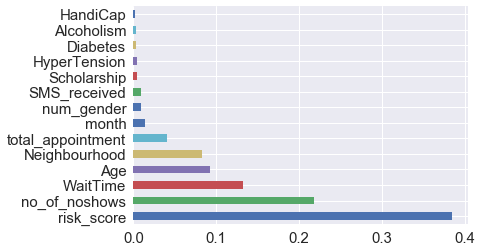

In [69]:
#we can see which are features that influenced the most in prediction 
feat_importances = pd.Series(base_model.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.show()

We could see that risk score influenced the prediction most. (risk score is the most important feature).Also we could see the other important features like waiting_time and age.

#### Logisttic Regression

In [59]:
 # fit_logistic

logit = LogisticRegression()
logit.fit(X_train, y_train) 


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
pred = logit.predict(X_test)
logit_accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f%%" % (logit_accuracy * 100.0))

Accuracy: 91.01%


In [61]:
logit.score(X_test, y_test)

0.9101228339548146

In [62]:
roc_auc_score(y_test, pred)

0.8336825852393459

### Neural Network Classifier

In [55]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100))
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [56]:
predictions = mlp.predict(X_test)

In [57]:
print(confusion_matrix(y_test,predictions))

[[ 5836  1494]
 [ 1523 27619]]


In [58]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.79      0.80      0.79      7330
          1       0.95      0.95      0.95     29142

avg / total       0.92      0.92      0.92     36472

